<a href="https://colab.research.google.com/github/AfroGrit/jenga-stock/blob/wk5/wk5/_forex_02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V


Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [2]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [3]:
!nvidia-smi  # this should display information about available GPUs


Mon Aug 12 17:32:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [86]:
import cudf  # GPU DataFrames

# Numerical and Data Handling
import numpy as np
import pandas as pd

# Financial Data Sources
import yfinance as yf
import pandas_datareader as pdr

# Data Visualization
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# Utilities
import time
from datetime import date
from tqdm import tqdm

# Machine Learning and Optimization
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'


import tensorflow as tf
import keras
from keras import layers
# from

# from datetime import datetime, timedelta

## smaller and tester files

In [6]:
# !gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/
# !gdown https://drive.google.com/file/d/1gtGV0NfHGreVoO_y5qCHLIWYmHOkFUua/view?usp=sharing --fuzzy -O /content/


In [7]:
# df = pd.read_parquet("/content/forexdf_2024_08_11.parquet.brotli", )
# df.info()

## production files

In [8]:
!gdown https://drive.google.com/file/d/1Js4I1JhnvRosGnA_grOrkbvtej81QG0S/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1Js4I1JhnvRosGnA_grOrkbvtej81QG0S
From (redirected): https://drive.google.com/uc?id=1Js4I1JhnvRosGnA_grOrkbvtej81QG0S&confirm=t&uuid=fc250faf-c163-4671-9922-ebe6c51daae5
To: /content/forexdf_2024_08_12.parquet.brotli
100% 105M/105M [00:01<00:00, 87.2MB/s]


In [9]:
df = pd.read_parquet("/content/forexdf_2024_08_12.parquet.brotli", )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179061 entries, 0 to 179060
Columns: 363 entries, Open to DGS10
dtypes: datetime64[ns](3), float64(289), int32(64), int64(5), object(2)
memory usage: 452.2+ MB


## prep & EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179061 entries, 0 to 179060
Columns: 363 entries, Open to DGS10
dtypes: datetime64[ns](3), float64(289), int32(64), int64(5), object(2)
memory usage: 452.2+ MB


In [11]:

# growth indicators (but not future growth)
GROWTH = [g for g in df.keys() if (g.find('growth_')==0)&(g.find('future')<0)]

# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_PREDICT = [g for g in df.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close'] + CATEGORICAL + OHLCV
df['ln_volume'] = df.Volume.apply(lambda x: np.log(x))

# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']


# MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
#  'DGS1_x', 'DGS1_y', 'DGS5', 'DGS10']

MACRO = [
    'gdppot_us_yoy',
    'gdppot_us_qoq',
    'cpi_core_yoy',
    'cpi_core_mom',
    'FEDFUNDS',
    'DGS1',
    'DGS5',
    'DGS10'
    ]

TECHNICAL_PATTERNS = [g for g in df.keys() if g.find('cdl')>=0]

NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

<ipython-input-11-c4e4977c89bc>:9: RuntimeWarning: divide by zero encountered in log
  df['ln_volume'] = df.Volume.apply(lambda x: np.log(x))


['growth_future_5d', 'is_positive_growth_5d_future']

In [12]:
df.Ticker.nunique()


32

In [13]:
df = df[df.Date>='2003-01-01']

In [14]:
# df.loc[:,'Month'] = df.Month.dt.strftime('%B')
# df.loc[:,'Weekday'] = df.Weekday.astype(str)

# Ensure the Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the month name and weekday from the Date column
df['Month'] = df['Date'].dt.strftime('%B')
df['Weekday'] = df['Date'].dt.strftime('%A')



In [15]:

# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

# examples of encoding
df.month_wom.value_counts()[0:2]



,count
month_wom,
April_w4,3376
March_w2,3372


In [16]:
# del wom temp variable
del df['wom']

In [17]:

# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [18]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [19]:
DUMMIES = dummy_variables.keys().to_list()

# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 172389 entries, 0 to 179060
Columns: 460 entries, growth_1d to month_wom_September_w5
dtypes: float64(283), int32(176), int64(1)
memory usage: 490.6 MB


## modelling

In [20]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df


In [21]:

min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)


df_with_dummies['split'].value_counts()/len(df_with_dummies)

,count
split,
train,0.686430
test,0.156855
validation,0.156715


In [22]:
model_df = df_with_dummies.copy()
model_df.groupby(['split'])['Date'].agg({'min','max','count'})


,count,min,max
split,,,
test,27040,2021-05-17,2024-08-12
train,118333,2003-01-01,2018-02-16
validation,27016,2018-02-19,2021-05-14


In [23]:
# what do we try to predict
model_df[TO_PREDICT].head(1)


,growth_future_5d,is_positive_growth_5d_future
0,1.012456,1


In [24]:
model_df[NUMERICAL+DUMMIES].tail()


,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_^GSPC_1d,growth_^GSPC_3d,growth_^GSPC_7d,growth_^GSPC_30d,...,month_wom_October_w1,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5
179056,1.006236,1.000000,0.980392,0.965724,0.975194,1.026457,1.010354,0.962059,0.959871,0.961849,...,0,0,0,0,0,0,0,0,0,0
179057,0.996986,0.994940,0.983959,0.967075,0.967286,1.025290,0.992265,0.972494,0.951672,0.950670,...,0,0,0,0,0,0,0,0,0,0
179058,1.005284,1.008503,0.990259,0.968691,0.972876,1.030050,1.023043,1.025640,0.978455,0.971049,...,0,0,0,0,0,0,0,0,0,0
179059,0.991006,0.993239,0.983872,0.954702,0.963862,1.020255,1.004672,1.019872,0.967742,0.974701,...,0,0,0,0,0,0,0,0,0,0
179060,0.998866,0.995112,0.992113,0.956545,0.960249,1.022945,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Manual 'rule of thumb' predictions

*   (pred0) CCI>200 (binary, on technical indicator CCI)
*   (pred1) growth_1d>1
*   (pred2) (growth_1d>1) & (growth_snp500_1d>1)
*   (pred3) (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
*   (pred4) (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

In [25]:
# """

# macro = ['Date', 'growth_SPY_1d', 'growth_SPY_3d', 'growth_SPY_7d',
#        'growth_SPY_30d', 'growth_SPY_90d', 'growth_SPY_365d', 'growth_ACWI_1d',
#        'growth_ACWI_3d', 'growth_ACWI_7d', 'growth_ACWI_30d',
#        'growth_ACWI_90d', 'growth_ACWI_365d', 'growth_TIP_1d', 'growth_TIP_3d',
#        'growth_TIP_7d', 'growth_TIP_30d', 'growth_TIP_90d', 'growth_TIP_365d',
#        'growth_SCHP_1d', 'growth_SCHP_3d', 'growth_SCHP_7d', 'growth_SCHP_30d',
#        'growth_SCHP_90d', 'growth_SCHP_365d', 'growth_TLT_1d', 'growth_TLT_3d',
#        'growth_TLT_7d', 'growth_TLT_30d', 'growth_TLT_90d', 'growth_TLT_365d',
#        'growth_VGSH_1d', 'growth_VGSH_3d', 'growth_VGSH_7d', 'growth_VGSH_30d',
#        'growth_VGSH_90d', 'growth_VGSH_365d']




# metals = ['Date', 'growth_GC=F_1d', 'growth_GC=F_3d', 'growth_GC=F_7d',
#        'growth_GC=F_30d', 'growth_GC=F_90d', 'growth_GC=F_365d',
#        'growth_SI=F_1d', 'growth_SI=F_3d', 'growth_SI=F_7d', 'growth_SI=F_30d',
#        'growth_SI=F_90d', 'growth_SI=F_365d', 'growth_PL=F_1d',
#        'growth_PL=F_3d', 'growth_PL=F_7d', 'growth_PL=F_30d',
#        'growth_PL=F_90d', 'growth_PL=F_365d', 'growth_PA=F_1d',
#        'growth_PA=F_3d', 'growth_PA=F_7d', 'growth_PA=F_30d',
#        'growth_PA=F_90d', 'growth_PA=F_365d']

# energy = ['Date', 'growth_GC=F_1d', 'growth_GC=F_3d', 'growth_GC=F_7d',
#        'growth_GC=F_30d', 'growth_GC=F_90d', 'growth_GC=F_365d',
#        'growth_SI=F_1d', 'growth_SI=F_3d', 'growth_SI=F_7d', 'growth_SI=F_30d',
#        'growth_SI=F_90d', 'growth_SI=F_365d', 'growth_PL=F_1d',
#        'growth_PL=F_3d', 'growth_PL=F_7d', 'growth_PL=F_30d',
#        'growth_PL=F_90d', 'growth_PL=F_365d', 'growth_PA=F_1d',
#        'growth_PA=F_3d', 'growth_PA=F_7d', 'growth_PA=F_30d',
#        'growth_PA=F_90d', 'growth_PA=F_365d']


# cryto = ['Date', 'growth_GC=F_1d', 'growth_GC=F_3d', 'growth_GC=F_7d',
#        'growth_GC=F_30d', 'growth_GC=F_90d', 'growth_GC=F_365d',
#        'growth_SI=F_1d', 'growth_SI=F_3d', 'growth_SI=F_7d', 'growth_SI=F_30d',
#        'growth_SI=F_90d', 'growth_SI=F_365d', 'growth_PL=F_1d',
#        'growth_PL=F_3d', 'growth_PL=F_7d', 'growth_PL=F_30d',
#        'growth_PL=F_90d', 'growth_PL=F_365d', 'growth_PA=F_1d',
#        'growth_PA=F_3d', 'growth_PA=F_7d', 'growth_PA=F_30d',
#        'growth_PA=F_90d', 'growth_PA=F_365d']

# """

In [26]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
model_df['pred0_manual_cci'] = (model_df.cci>200).astype(int)
model_df['pred1_manual_prev_g1'] = (model_df.growth_1d>1).astype(int)
model_df['pred2_manual_prev_g1_and_snp'] = ((model_df['growth_1d'] > 1) & (model_df['growth_SPY_1d'] > 1)).astype(int)


# new manual predictions from HA
model_df['pred3_manual_gdp_and_fastd'] = ((model_df['gdppot_us_yoy'] <= 0.027) & (model_df['fastd'] >=0.251)).astype(int)
model_df['pred4_manual_gdp_and_wti30d'] = ((model_df['gdppot_us_yoy'] >= 0.027) & (model_df['growth_CL=F_30d'] <= 1.005)).astype(int)


model_df[
    [
        'cci',
        'growth_1d',
        'growth_SPY_1d',
        'pred0_manual_cci',
        'pred1_manual_prev_g1',
        'pred2_manual_prev_g1_and_snp',
        'pred3_manual_gdp_and_fastd',
        'pred4_manual_gdp_and_wti30d',
        'is_positive_growth_5d_future'
    ]
  ]


,cci,growth_1d,growth_SPY_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_positive_growth_5d_future
0,NaN,NaN,1.010804,0,0,0,0,0,1
1,NaN,0.992558,0.997490,0,0,0,0,0,1
2,NaN,0.983686,0.998416,0,0,0,0,0,1
3,NaN,1.023044,1.004107,0,1,1,0,0,1
4,NaN,0.981847,0.993030,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
179056,-92.973311,1.006236,1.009220,0,1,1,1,0,0
179057,-73.643618,0.996986,0.993316,0,0,0,1,0,0
179058,-71.343271,1.005284,1.023117,0,1,1,1,0,0
179059,-103.369048,0.991006,1.004410,0,0,0,1,0,0


In [27]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (model_df[pred] == model_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (model_df.split=='test') & (model_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(model_df[filter][is_correct_column].value_counts())
    print(model_df[filter][is_correct_column].value_counts()/len(model_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [28]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(model_df, to_predict='is_positive_growth_5d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    352
0    275
Name: count, dtype: int64
is_correct_pred0
1    0.561404
0    0.438596
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    7703
0    6310
Name: count, dtype: int64
is_correct_pred1
1    0.549704
0    0.450296
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    3733
0    3264
Name: count, dtype: int64
is_correct_pred2
1    0.533514
0    0.466486
Name: count, dtype: float64
-

In [29]:
model_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_5d_future']]


,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,0,1,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
179056,0,1,1,1,0,1,0,0,0,1,0
179057,0,0,0,1,0,1,1,1,0,1,0
179058,0,1,1,1,0,1,0,0,0,1,0
179059,0,0,0,1,0,1,1,1,0,1,0


In [30]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [31]:
len(model_df[model_df.split=='test'])


27040

In [32]:
model_df[(model_df['gdppot_us_yoy'] >= 0.027) & (model_df['growth_CL=F_30d'] <= 1.005)]


,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4


<Axes: xlabel='Date'>

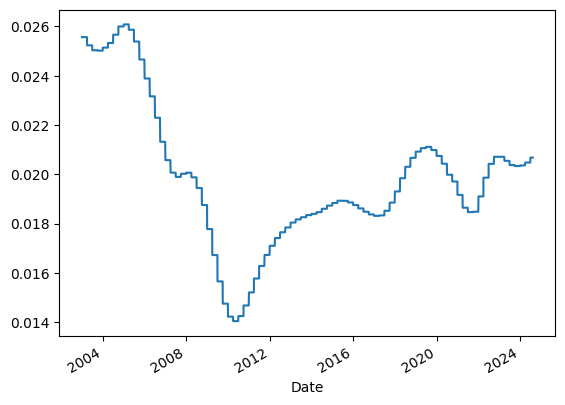

In [33]:
model_df.groupby('Date')['gdppot_us_yoy'].max().plot.line()


## 1.0 Decision Tree Classifier


In [34]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df


# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [35]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_5d_future'

train_valid_df = model_df[model_df.split.isin(['train','validation'])].copy(deep=True)
test_df = model_df[model_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe model_df
X_all =  model_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')


length: X_train_valid (145349, 461),  X_test (27040, 461), all combined: X_all (172389, 461)


In [36]:
X_train_valid[to_predict]

,is_positive_growth_5d_future
0,1
1,1
2,1
3,1
4,1
...,...
178211,1
178212,1
178213,1
178214,1


In [37]:

# Clean from +-inf and NaNs:

X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
# X_test = clean_dataframe_from_inf_and_nan(X_test) # won't use
X_all = clean_dataframe_from_inf_and_nan(X_all)



In [38]:
X_train_valid.keys()

Index(['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d',
       'growth_365d', 'growth_^GSPC_1d', 'growth_^GSPC_3d', 'growth_^GSPC_7d',
       'growth_^GSPC_30d',
       ...
       'month_wom_October_w2', 'month_wom_October_w3', 'month_wom_October_w4',
       'month_wom_October_w5', 'month_wom_September_w1',
       'month_wom_September_w2', 'month_wom_September_w3',
       'month_wom_September_w4', 'month_wom_September_w5',
       'is_positive_growth_5d_future'],
      dtype='object', length=461)

In [39]:

y_train_valid = X_train_valid[to_predict]
# y_test = X_test[to_predict] # won't use
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]




In [40]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 35.7 s, sys: 156 ms, total: 35.8 s
Wall time: 35.7 s


In [41]:

# predict on a full dataset
y_pred_all = clf_10.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
model_df['pred5_clf_10'] = y_pred_all

In [42]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(model_df, to_predict='is_positive_growth_5d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    352
0    275
Name: count, dtype: int64
is_correct_pred0
1    0.561404
0    0.438596
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    7703
0    6310
Name: count, dtype: int64
is_correct_pred1
1    0.549704
0    0.450296
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    3733
0    3264
Name: count, dtype: int64
is_correct_pred2
1    0.533514
0    0.

In [43]:
IS_CORRECT


['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

In [44]:

# define a new column that find the cases when only pred5 is correct
model_df['only_pred5_is_correct'] = (model_df.is_correct_pred5==model_df.is_positive_growth_5d_future) & \
                         (model_df.is_positive_growth_5d_future == 1) & \
                         (model_df.is_correct_pred0 == 0) & \
                         (model_df.is_correct_pred1 == 0) & \
                         (model_df.is_correct_pred2 == 0) & \
                         (model_df.is_correct_pred3 == 0) & \
                         (model_df.is_correct_pred4 == 0)


# need it to be integer and not bool
model_df['only_pred5_is_correct'] = model_df['only_pred5_is_correct'].astype(int)


# how many times only pred5 is correct in the TEST set?
model_df[model_df.split=='test']['only_pred5_is_correct'].sum()

21

In [45]:

# let's look at the record
filter_unique_pred_5 = (model_df.split=='test') & (model_df.only_pred5_is_correct==1)


model_df[filter_unique_pred_5]

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10,is_correct_pred5,only_pred5_is_correct
22110,459.970001,459.970001,459.950012,456.000000,456.000000,0.0,USDNGN=X,2023,February,Wednesday,...,0,0,0,0,0,0,0,1,1,1
22114,459.950012,459.970001,459.940002,458.000000,458.000000,0.0,USDNGN=X,2023,February,Tuesday,...,0,0,0,0,0,0,0,1,1,1
22171,460.200012,460.359985,459.000000,459.000000,459.000000,0.0,USDNGN=X,2023,May,Thursday,...,0,0,0,0,0,0,0,1,1,1
22186,461.179993,465.510010,461.179993,460.000000,460.000000,0.0,USDNGN=X,2023,June,Thursday,...,0,0,0,0,0,0,0,1,1,1
22282,763.500000,765.349976,763.500000,749.000000,749.000000,0.0,USDNGN=X,2023,October,Friday,...,0,0,0,0,0,0,0,1,1,1
22284,764.646973,768.219971,764.409973,764.580017,764.580017,0.0,USDNGN=X,2023,October,Tuesday,...,0,0,0,0,0,0,0,1,1,1
31571,6.057595,6.057595,5.970000,5.940000,5.940000,0.0,USDGHS=X,2021,September,Thursday,...,0,0,0,0,0,0,0,1,1,1
31636,6.078832,6.164587,6.020000,6.020000,6.020000,0.0,USDGHS=X,2021,December,Thursday,...,0,0,0,0,0,0,0,1,1,1
31732,7.541808,7.545500,7.250000,7.250000,7.250000,0.0,USDGHS=X,2022,May,Friday,...,0,0,0,0,0,0,0,1,1,1
31856,13.767254,13.767254,13.649897,13.200000,13.200000,0.0,USDGHS=X,2022,November,Thursday,...,0,0,0,0,0,0,0,1,1,1


In [46]:
model_df[filter_unique_pred_5][PREDICTIONS+IS_CORRECT+['is_positive_growth_5d_future']]


,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,pred5_clf_10,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_correct_pred5,is_positive_growth_5d_future
22110,0,0,0,0,0,1,0,0,0,0,0,1,1
22114,0,0,0,0,0,1,0,0,0,0,0,1,1
22171,0,0,0,0,0,1,0,0,0,0,0,1,1
22186,0,0,0,0,0,1,0,0,0,0,0,1,1
22282,0,0,0,0,0,1,0,0,0,0,0,1,1
22284,0,0,0,0,0,1,0,0,0,0,0,1,1
31571,0,0,0,0,0,1,0,0,0,0,0,1,1
31636,0,0,0,0,0,1,0,0,0,0,0,1,1
31732,0,0,0,0,0,1,0,0,0,0,0,1,1
31856,0,0,0,0,0,1,0,0,0,0,0,1,1


In [47]:

# double-check: let's rerun the prediction only on this record with uniquely correct prediction 5:
X_1 = model_df[filter_unique_pred_5][NUMERICAL+DUMMIES].fillna(0)
X_1 = clean_dataframe_from_inf_and_nan(X_1)
p = clf_10.predict(X_1)
print(f'True value ={model_df[filter_unique_pred_5].loc[:,to_predict].to_list()}, prediction from clf_10:{p}')

True value =[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], prediction from clf_10:[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Hyperparams tuning for a Decision Tree Classifier

In [48]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_5d_future'

train_df = model_df[model_df.split.isin(['train'])].copy(deep=True)
valid_df = model_df[model_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = model_df[model_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  model_df[model_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe model_df
X_all =  model_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')


length: X_train (118333, 461),  X_validation (27016, 461), X_test (27040, 461), X_train_valid = (145349, 461),  all combined: X_all (172389, 461)


In [49]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)

X_test = clean_dataframe_from_inf_and_nan(X_test)

X_all = clean_dataframe_from_inf_and_nan(X_all)


y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

In [50]:
%%time
# hyper params tuning for a Decision Tree

precision_by_depth = {}
best_precision = 0
best_depth = 0

for depth in range(1,21):
  print(f'Working with a tree of a max depth= {depth}')
  # fitting the tree on X_train, y_train
  clf,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=depth) #applying custom hyperparam
  # getting the predictions for TEST and accuracy score
  y_pred_valid = clf.predict(X_valid)
  precision_valid = precision_score(y_valid, y_pred_valid)
  y_pred_test = clf.predict(X_test)
  precision_test = precision_score(y_test, y_pred_test)
  print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
  # saving to the dict
  precision_by_depth[depth] = round(precision_test,4)
  # updating the best precision
  if precision_test >= best_precision:
    best_precision = round(precision_test,4)
    best_depth = depth
  # plot tree - long
  # plt.figure(figsize=(20,10))  # Set the size of the figure
  # plot_tree(clf,
  #           filled=True,
  #           feature_names=train_columns,
  #           class_names=['Negative', 'Positive'],
  #           max_depth=2)
  # plt.show()
  # plot tree - short
  tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
  print(tree_rules)
  print('------------------------------')

print(f'All precisions by depth: {precision_by_depth}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

Working with a tree of a max depth= 1
  Precision on test is 0.7186093046523262, (precision on valid is 0.685921625544267 - tend to overfit)
|--- cdlgravestonedoji <= 50.00
|   |--- class: 0
|--- cdlgravestonedoji >  50.00
|   |--- class: 1

------------------------------
Working with a tree of a max depth= 2
  Precision on test is 0.7186093046523262, (precision on valid is 0.685921625544267 - tend to overfit)
|--- cdlgravestonedoji <= 50.00
|   |--- cdldragonflydoji <= 50.00
|   |   |--- class: 0
|   |--- cdldragonflydoji >  50.00
|   |   |--- class: 0
|--- cdlgravestonedoji >  50.00
|   |--- high_minus_low_relative <= 0.01
|   |   |--- class: 1
|   |--- high_minus_low_relative >  0.01
|   |   |--- class: 1

------------------------------
Working with a tree of a max depth= 3
  Precision on test is 0.5785299471266361, (precision on valid is 0.5445548987999284 - tend to overfit)
|--- cdlgravestonedoji <= 50.00
|   |--- cdldragonflydoji <= 50.00
|   |   |--- cdlclosingmarubozu <= 50.00


```
All precisions by depth: {1: 0.7186, 2: 0.7186, 3: 0.5785, 4: 0.7223, 5: 0.747, 6: 0.6206, 7: 0.6387, 8: 0.6413, 9: 0.6266, 10: 0.6349, 11: 0.6172, 12: 0.6036, 13: 0.6175, 14: 0.6002, 15: 0.5936, 16: 0.5812, 17: 0.5819, 18: 0.5711, 19: 0.5727, 20: 0.5692}
The best precision is 0.747 and the best depth is 5
CPU times: user 12min 52s, sys: 3.77 s, total: 12min 56s
Wall time: 12min 59s
```

In [51]:
precision_by_depth


{1: 0.7186,
 2: 0.7186,
 3: 0.5785,
 4: 0.7223,
 5: 0.747,
 6: 0.6206,
 7: 0.6387,
 8: 0.6413,
 9: 0.6266,
 10: 0.6349,
 11: 0.6172,
 12: 0.6036,
 13: 0.6175,
 14: 0.6002,
 15: 0.5936,
 16: 0.5812,
 17: 0.5819,
 18: 0.5711,
 19: 0.5727,
 20: 0.5692}

In [52]:

# pre-calculated results from above
precision_by_depth_precalculated ={
    1: 0.7186,
    2: 0.7186,
    3: 0.5785,
    4: 0.7223,
    5: 0.747,
    6: 0.6206,
    7: 0.6387,
    8: 0.6413,
    9: 0.6266,
    10: 0.6349,
    11: 0.6172,
    12: 0.6036,
    13: 0.6175,
    14: 0.6002,
    15: 0.5936,
    16: 0.5812,
    17: 0.5819,
    18: 0.5711,
    19: 0.5727,
    20: 0.5692
    }

In [53]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth_precalculated.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 80],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [54]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')


Best precision and depth = 5, precision (on test)=0.747


In [55]:
# found earlier in HyperParams Tuning


%%time

best_depth=5

clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 16.7 s, sys: 156 ms, total: 16.8 s
Wall time: 16.7 s


In [56]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 63
Number of leaves: 32


In [57]:
clf_best


DecisionTreeClassifier(max_depth=5, random_state=42)

In [58]:

# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
model_df['pred6_clf_best'] = y_pred_clf_best

In [59]:

# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(model_df, to_predict='is_positive_growth_5d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    352
0    275
Name: count, dtype: int64
is_correct_pred0
1    0.561404
0    0.438596
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    7703
0    6310
Name: count, dtype: int64
is_correct_pred1
1    0.549704
0    0.450296
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    3733
0    3264
Name: count, dtype: int64


In [60]:
from sklearn.ensemble import RandomForestClassifier


In [61]:
%%time
# hyper params tuning

precision_matrix = {}
best_precision = 0
best_depth = 0
best_estimators = 1

for depth in [15, 16, 17, 18, 19, 20]:
  for estimators in [50,100,200,500]:
    print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

    # Start timing
    start_time = time.time()
    # fitting the tree on X_train, y_train
    rf = RandomForestClassifier(n_estimators = estimators,
                                max_depth = depth,
                                random_state = 42,
                                n_jobs = -1)

    rf = rf.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = rf.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = rf.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

    # saving to the dict
    precision_matrix[depth, estimators] = round(precision_test,4)

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

    # updating the best precision
    if precision_test >= best_precision:
      best_precision = round(precision_test,4)
      best_depth = depth
      best_estimators = estimators
      print(f'New best precision found for depth={depth}, estimators = {estimators}')

    print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

Working with HyperParams: depth = 15, estimators = 50
  Precision on test is 0.6278635199667797, (precision on valid is 0.8979804754452642 - tend to overfit)
Time for training: 16.24 seconds, or 0.27 minutes
New best precision found for depth=15, estimators = 50
------------------------------
Working with HyperParams: depth = 15, estimators = 100
  Precision on test is 0.6392565667649681, (precision on valid is 0.9132965229070288 - tend to overfit)
Time for training: 30.90 seconds, or 0.52 minutes
New best precision found for depth=15, estimators = 100
------------------------------
Working with HyperParams: depth = 15, estimators = 200
  Precision on test is 0.6430327868852459, (precision on valid is 0.9142559678738752 - tend to overfit)
Time for training: 60.11 seconds, or 1.00 minutes
New best precision found for depth=15, estimators = 200
------------------------------
Working with HyperParams: depth = 15, estimators = 500
  Precision on test is 0.6454102355808286, (precision on va

In [62]:
precision_matrix

{(15, 50): 0.6279,
 (15, 100): 0.6393,
 (15, 200): 0.643,
 (15, 500): 0.6454,
 (16, 50): 0.6282,
 (16, 100): 0.6401,
 (16, 200): 0.6481,
 (16, 500): 0.6491,
 (17, 50): 0.6285,
 (17, 100): 0.6343,
 (17, 200): 0.6438,
 (17, 500): 0.6444,
 (18, 50): 0.6214,
 (18, 100): 0.634,
 (18, 200): 0.6416,
 (18, 500): 0.643,
 (19, 50): 0.6252,
 (19, 100): 0.6368,
 (19, 200): 0.6401,
 (19, 500): 0.6487,
 (20, 50): 0.6197,
 (20, 100): 0.6296,
 (20, 200): 0.6351,
 (20, 500): 0.6442}

In [ ]:
# precalc above

best_precision_matrix_random_forest = {
    (15, 50): 0.6279,
    (15, 100): 0.6393,
    (15, 200): 0.643,
    (15, 500): 0.6454,
    (16, 50): 0.6282,
    (16, 100): 0.6401,
    (16, 200): 0.6481,
    (16, 500): 0.6491,
    (17, 50): 0.6285,
    (17, 100): 0.6343,
    (17, 200): 0.6438,
    (17, 500): 0.6444,
    (18, 50): 0.6214,
    (18, 100): 0.634,
    (18, 200): 0.6416,
    (18, 500): 0.643,
    (19, 50): 0.6252,
    (19, 100): 0.6368,
    (19, 200): 0.6401,
    (19, 500): 0.6487,
    (20, 50): 0.6197,
    (20, 100): 0.6296,
    (20, 200): 0.6351,
    (20, 500): 0.6442
    }

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

In [65]:
%%time

# Suboptimal Predictor with less (than optimal) Estimators (500) and lower Max_Depth (16)
# several minutes to compute (6 min)

rf_best = RandomForestClassifier(n_estimators = 500,
                                 max_depth = 16,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)


CPU times: user 19min 59s, sys: 1 s, total: 20min
Wall time: 2min 37s


## 2.0.Logistic Regression


In [66]:
from sklearn.linear_model import LogisticRegression
precision_matrix = {}
best_precision = 0
best_C = 0
best_iter = 0

# for c in [1, 0.5, 0.1, 0.01]:
for c in [0.25, 0.1, 0.05,  0.01]:
  for iter in [50, 100, 200]:
    print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
    # fitting the tree on X_train, y_train
      # hyperParam C should be between 0 and 1
    lr = LogisticRegression(C=c,
                            random_state=42,
                            max_iter=iter,
                            solver='sag',
                            n_jobs=-1)

    lr = lr.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = lr.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = lr.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
    # saving to the dict
    precision_matrix[(c,iter)] = round(precision_test,4)
    # updating the best precision
    if precision_test >= best_precision:
      best_precision = round(precision_test,4)
      best_C = c
      best_iter = iter
      print(f'New best precision found for C={c}')
      print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

Working with HyperParams: C = 0.25 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6115459882583171, (precision on valid is 0.5844535821603669 - tend to overfit)
New best precision found for C=0.25
------------------------------
Working with HyperParams: C = 0.25 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6131191432396251, (precision on valid is 0.5865281808461891 - tend to overfit)
New best precision found for C=0.25
------------------------------
Working with HyperParams: C = 0.25 (positive float, smaller = stronger regularization), max_iter=200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6147371147371148, (precision on valid is 0.5896128841607565 - tend to overfit)
New best precision found for C=0.25
------------------------------
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6115459882583171, (precision on valid is 0.5844535821603669 - tend to overfit)
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6131191432396251, (precision on valid is 0.5865281808461891 - tend to overfit)
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6147371147371148, (precision on valid is 0.5896128841607565 - tend to overfit)
New best precision found for C=0.1
------------------------------
Working with HyperParams: C = 0.05 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6115459882583171, (precision on valid is 0.5844535821603669 - tend to overfit)
Working with HyperParams: C = 0.05 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6131191432396251, (precision on valid is 0.5865281808461891 - tend to overfit)
Working with HyperParams: C = 0.05 (positive float, smaller = stronger regularization), max_iter=200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6147371147371148, (precision on valid is 0.5896128841607565 - tend to overfit)
New best precision found for C=0.05
------------------------------
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6115459882583171, (precision on valid is 0.5844535821603669 - tend to overfit)
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Precision on test is 0.6131191432396251, (precision on valid is 0.5865281808461891 - tend to overfit)
Working with HyperParams: C = 0.01 (positive float, smaller = stronger regularization), max_iter=200
  Precision on test is 0.6147371147371148, (precision on valid is 0.5896128841607565 - tend to overfit)
New best precision found for C=0.01
------------------------------
Matrix of precisions: {(0.25, 50): 0.6115, (0.25, 100): 0.6131, (0.25, 200): 0.6147, (0.1, 50): 0.6115, (0.1, 100): 0.6131, (0.1, 200): 0.6147, (0.05, 50): 0.6115, (0.05, 100): 0.6131, (0.05, 200): 0.6147, (0.01, 50): 0.6115, (0.01, 100): 0.6131, (0.01, 200): 0.6147}
The best precision is 0.6147 and the best C is 0.01, best max_iter = 200  


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [69]:
precision_matrix

{(0.25, 50): 0.6115,
 (0.25, 100): 0.6131,
 (0.25, 200): 0.6147,
 (0.1, 50): 0.6115,
 (0.1, 100): 0.6131,
 (0.1, 200): 0.6147,
 (0.05, 50): 0.6115,
 (0.05, 100): 0.6131,
 (0.05, 200): 0.6147,
 (0.01, 50): 0.6115,
 (0.01, 100): 0.6131,
 (0.01, 200): 0.6147}

In [ ]:
# Matrix of precisions: {(0.25, 50): 0.6115, (0.25, 100): 0.6131, (0.25, 200): 0.6147, (0.1, 50): 0.6115, (0.1, 100): 0.6131, (0.1, 200): 0.6147, (0.05, 50): 0.6115, (0.05, 100): 0.6131, (0.05, 200): 0.6147, (0.01, 50): 0.6115, (0.01, 100): 0.6131, (0.01, 200): 0.6147}
# The best precision is 0.6147 and the best C is 0.01, best max_iter = 200


In [70]:
best_precision_matrix_logistic_regression = {
    (0.25, 50): 0.6115,
    (0.25, 100): 0.6131,
    (0.25, 200): 0.6147,
    (0.1, 50): 0.6115,
    (0.1, 100): 0.6131,
    (0.1, 200): 0.6147,
    (0.05, 50): 0.6115,
    (0.05, 100): 0.6131,
    (0.05, 200): 0.6147,
    (0.01, 50): 0.6115,
    (0.01, 100): 0.6131,
    (0.01, 200): 0.6147
    }

In [71]:


# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of ',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

In [68]:
%%time



# # Split your data into training, validation, and test sets
# X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)

def objective(trial):
    # Suggest values for C and max_iter
    c = trial.suggest_float('C', 0.01, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 300)

    # Define the model with the suggested hyperparameters
    lr = LogisticRegression(
        C=c,
        random_state=42,
        max_iter=max_iter,
        solver='sag',
        n_jobs=-1
    )

    # Train the model
    lr.fit(X_train_valid, y_train_valid)

    # Validate the model
    y_pred_valid = lr.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)

    # Return the precision score (Optuna minimizes, so we use -precision)
    return -precision_valid

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
best_C = best_params['C']
best_iter = best_params['max_iter']

# Train and test the final model with the best parameters
lr = LogisticRegression(
    C=best_C,
    random_state=42,
    max_iter=best_iter,
    solver='sag',
    n_jobs=-1
)

lr.fit(X_train_valid, y_train_valid)
y_pred_test = lr.predict(X_test)
best_precision = precision_score(y_test, y_pred_test)

print(f'The best precision is {best_precision} with C={best_C} and max_iter={best_iter}')


[I 2024-08-12 18:43:13,294] A new study created in memory with name: no-name-a0c91e00-eeda-4ecf-ac0d-0a1638e8e235
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2024-08-12 18:43:56,247] Trial 0 finished with value: -0.584757723067273 and parameters: {'C': 0.06398605740921001, 'max_iter': 59}. Best is trial 0 with value: -0.584757723067273.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2024-08-12 18:45:29,435] Trial 1 finished with value: -0.5879912499057102 and parameters: {'C': 0.02475720713152545, 'max_iter': 127}. Best is trial 0 with value: -0.584757723067273.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2024-08-12 18:46:24,355] Trial 2 

The best precision is 0.6115459882583171 with C=0.011156706009819743 and max_iter=50


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
# The best precision is 0.6115459882583171 with C=0.011156706009819743 and max_iter=50


## 3.0 Neural Network (NN) and HyperParams tuning

In [72]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [75]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 460}

In [85]:
import datetime


# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [76]:
model = build_model(nn_params)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         118,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,065 (719.00 KB)

 Trainable params: 184,065 (719.00 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.count_params()


184065

In [78]:

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')


In [87]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [88]:
%%time

# returns best_model (trained) and best_history (history of train operations)
best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
                                                                 MAX_MODELS=2, #not more than 2 models
                                                                 MAX_EPOCHS=250,
                                                                 EARLY_STOPPING_PATIENCE=10)


Using HyperParams:{'learning_rate': 0.1, 'first_layer_neurons': 12, 'first_layer_dropout': 0.1, 'second_layer_neurons': 12, 'second_layer_dropout': 0.1, 'activation_first_layer': 'relu', 'activation_second_layer': 'relu', 'optimizer': 'adam', 'input_shape': 460}
Training model 1 with trainable params 5701 :
Epoch 1/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5013 - loss: 0.9768 - precision_4: 0.4934
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5013 - loss: 0.9768 - precision_4: 0.4934 - val_accuracy: 0.5445 - val_loss: 0.6928 - val_precision_4: 0.5445
Epoch 2/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5019 - loss: 0.7069 - precision_4: 0.4935 - val_accuracy: 0.4556 - val_loss: 0.6936 - val_precision_4: 1.0000
Epoch 3/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5025 - loss: 0.6930 - precision_4: 0.4968 - val_accuracy: 0.5445 - val_loss: 0.6930 - val_precision_4: 0.5445
Epoch 4/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5044 - loss: 1.1842 - precision_5: 0.4998
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5044 - loss: 1.1841 - precision_5: 0.4998 - val_accuracy: 0.4555 - val_loss: 0.7122 - val_precision_5: 0.3333
Epoch 2/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4988 - loss: 0.7526 - precision_5: 0.4811 - val_accuracy: 0.4555 - val_loss: 0.7102 - val_precision_5: 0.3333
Epoch 3/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5042 - loss: 0.7073 - precision_5: 0.5386 - val_accuracy: 0.4555 - val_loss: 0.7056 - val_precision_5: 0.0000e+00
Epoch 4/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5053 - loss: 0.9225 - precision_5: 0.5958 - val_accuracy: 0.5445 - val_loss: 0.6932 - val_precision_5: 0.5445
Epoch 5/250
4543/4543 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5019 - loss: 0.7093 - precision_5: 0.4903 - val_accuracy: 0.4555 - val_loss: 0.6943 - val_precision_5: 0.5000
E

In [89]:


best_history_nn = best_history
best_model_nn = best_model


best_model_nn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 12)                  │           5,532 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,404 (44.55 KB)

 Trainable params: 5,701 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,703 (22.28 KB)

In [95]:
best_history_nn.keys()

dict_keys(['accuracy', 'loss', 'precision_4', 'val_accuracy', 'val_loss', 'val_precision_4'])

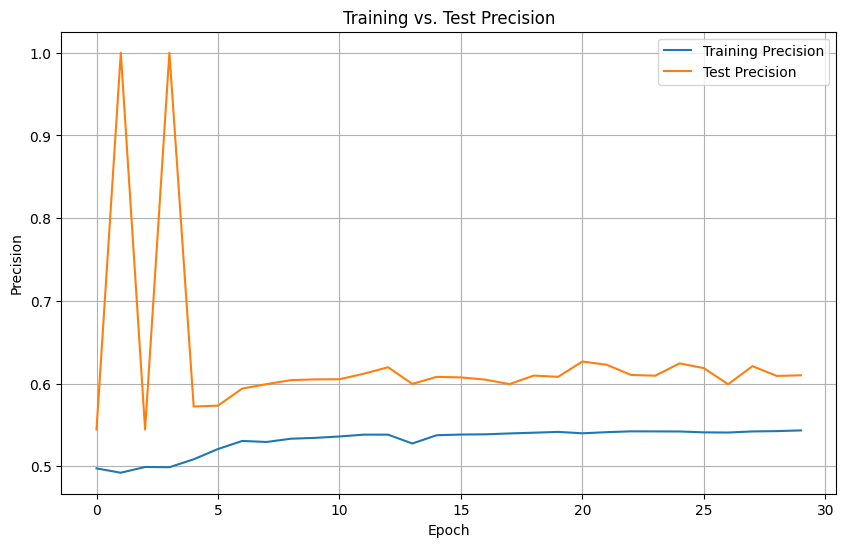

In [96]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_4'], label='Training Precision')
plt.plot(best_history_nn['val_precision_4'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

### Different Decision rules to improve the Precision (varying Threshold)

In [97]:
# predicting probability instead of a lable

y_pred_test = clf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.492359
1,0.254804
2,0.492359
3,0.254804
4,0.492359


In [102]:
y_pred_test_class1_df.describe().T, y_test.sum()/y_test.count()



(                      count      mean       std       min       25%       50%  \
 Class1_probability  27040.0  0.502455  0.106315  0.254804  0.492359  0.492359   
 
                          75%       max  
 Class1_probability  0.492359  0.921502  ,
 0.5444526627218935)

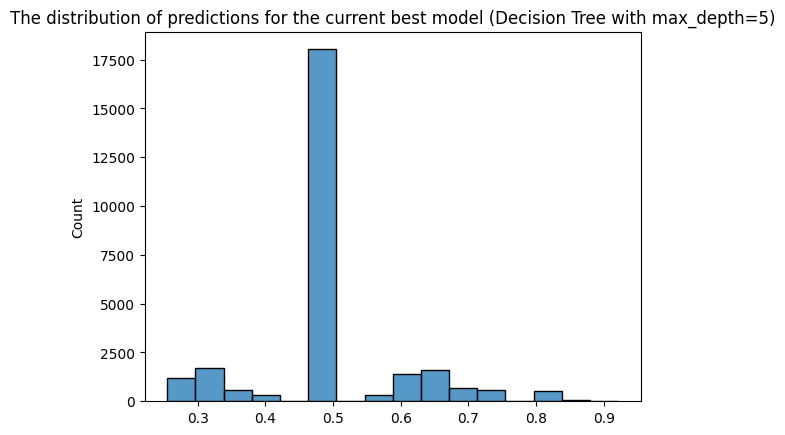

In [108]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=5)')

# Show the plot
plt.show()

In [109]:
def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
  scores = []

  if only_even==False:
    thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
  else:
    thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

  for t in thresholds:

      actual_positive = (y_true == 1)
      actual_negative = (y_true == 0)

      predict_positive = (y_pred >= t)
      predict_negative = (y_pred < t)

      tp = (predict_positive & actual_positive).sum()
      tn = (predict_negative & actual_negative).sum()

      fp = (predict_positive & actual_negative).sum()
      fn = (predict_negative & actual_positive).sum()

      if tp + fp > 0:
        precision = tp / (tp + fp)

      if tp + fn > 0:
        recall = tp / (tp + fn)

      if precision+recall > 0:
        f1_score = 2*precision*recall / (precision+recall)

      accuracy = (tp+tn) / (tp+tn+fp+fn)

      scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

  columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
  df_scores = pd.DataFrame(scores, columns=columns)

  df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
  df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

  return df_scores



df_scores = tpr_fpr_dataframe(y_test, y_pred_test_class1, only_even=True)
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]


,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,3918,1327,10804,10991,0.746997,0.266132,0.551368,0.392448,0.266132,0.107729
26,0.52,3918,1327,10804,10991,0.746997,0.266132,0.551368,0.392448,0.266132,0.107729
27,0.54,3918,1327,10804,10991,0.746997,0.266132,0.551368,0.392448,0.266132,0.107729
28,0.56,3918,1327,10804,10991,0.746997,0.266132,0.551368,0.392448,0.266132,0.107729
29,0.58,3680,1224,11042,11094,0.750408,0.249966,0.546376,0.375013,0.249966,0.099367
30,0.60,3109,991,11613,11327,0.758293,0.211181,0.533876,0.330358,0.211181,0.080451
31,0.62,3109,991,11613,11327,0.758293,0.211181,0.533876,0.330358,0.211181,0.080451
32,0.64,2515,955,12207,11363,0.724784,0.170833,0.513240,0.276495,0.170833,0.077529
33,0.66,1394,477,13328,11841,0.745056,0.094688,0.489460,0.168023,0.094688,0.038724
34,0.68,1394,477,13328,11841,0.745056,0.094688,0.489460,0.168023,0.094688,0.038724


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=5)'}, xlabel='threshold'>

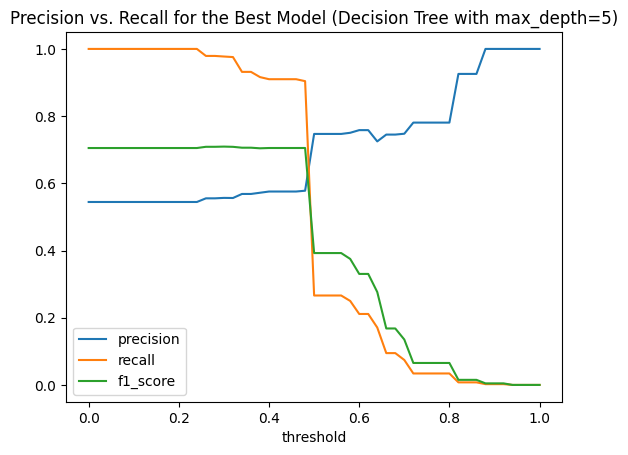

In [110]:
df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=5)')

In [112]:

y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
model_df['proba_pred7'] = y_pred_all_class1_array
model_df['pred7_clf_best_rule_66'] = (y_pred_all_class1_array >= 0.66).astype(int)

model_df['proba_pred8'] = y_pred_all_class1_array
model_df['pred8_clf_best_rule_78'] = (y_pred_all_class1_array >= 0.78).astype(int)

In [113]:
rf_best


RandomForestClassifier(max_depth=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [114]:

# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
model_df['proba_pred9'] = y_pred_all_class1_array
model_df['pred9_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

model_df['proba_pred10'] = y_pred_all_class1_array
model_df['pred10_rf_best_rule_60'] = (y_pred_all_class1_array >= 0.6).astype(int)

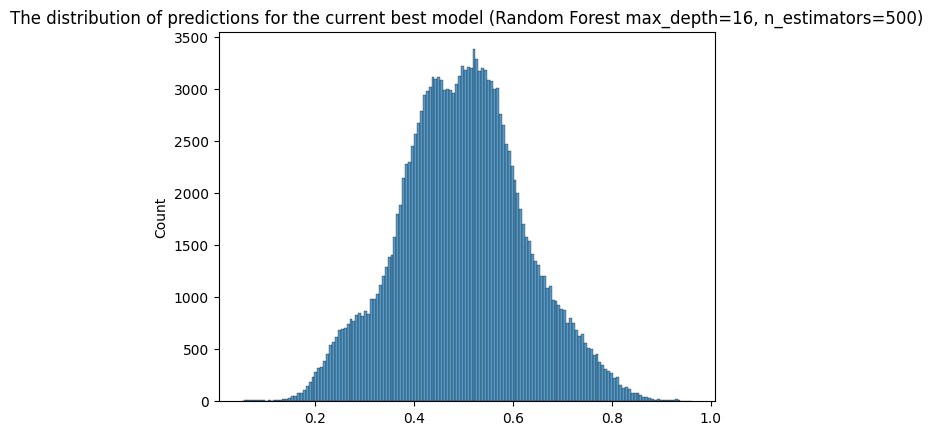

In [116]:
# PREDICTIONS ON A FULL DATASET:
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Random Forest max_depth=16, n_estimators=500)')

# Show the plot
plt.show()

<Axes: >

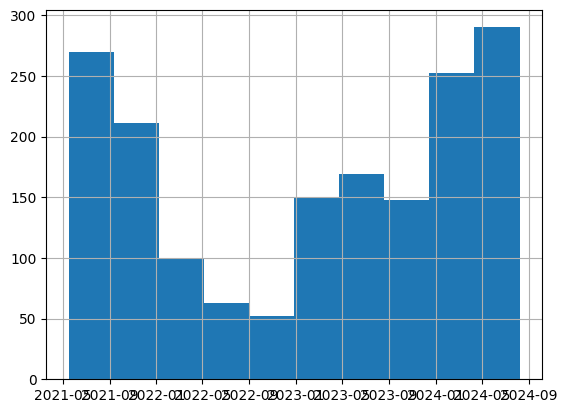

In [117]:

# When did it predict to trade for the "rare" prediction pred10? (only 2%)
model_df[(model_df.split=='test')&(model_df.pred10_rf_best_rule_60==1)].Date.hist()

In [118]:
model_df[(model_df.split=='test')&(model_df.pred10_rf_best_rule_60==1)].sort_values(by='Date')


,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,pred6_clf_best,is_correct_pred6,proba_pred7,pred7_clf_best_rule_66,proba_pred8,pred8_clf_best_rule_78,proba_pred9,pred9_rf_best_rule_55,proba_pred10,pred10_rf_best_rule_60
87038,93.911903,94.143692,93.757797,93.895752,93.895752,0.0,USDARS=X,2021,May,Monday,...,1,1,0.626866,0,0.626866,0,0.653918,1,0.653918,1
133413,9.985030,10.072400,9.979170,9.984740,9.984740,0.0,EURNOK=X,2021,May,Monday,...,1,1,0.707317,1,0.707317,0,0.654074,1,0.654074,1
70854,0.777350,0.781360,0.776900,0.777370,0.777370,0.0,AUDUSD=X,2021,May,Tuesday,...,1,0,0.653813,0,0.653813,0,0.612633,1,0.612633,1
55231,1.414847,1.422050,1.414687,1.414867,1.414867,0.0,GBPUSD=X,2021,May,Tuesday,...,1,1,0.653813,0,0.653813,0,0.613839,1,0.613839,1
87039,94.057404,94.174301,93.982933,94.047302,94.047302,0.0,USDARS=X,2021,May,Tuesday,...,1,1,0.626866,0,0.626866,0,0.731625,1,0.731625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77466,7.120200,7.156300,7.118500,7.120200,7.120200,0.0,USDCNY=X,2024,August,Tuesday,...,1,0,0.595345,0,0.595345,0,0.616820,1,0.616820,1
50688,144.731995,147.822006,144.554001,144.731995,144.731995,0.0,USDJPY=X,2024,August,Wednesday,...,1,0,0.706522,1,0.706522,0,0.619767,1,0.619767,1
87879,935.486511,936.513000,935.276428,935.486511,935.486511,0.0,USDARS=X,2024,August,Wednesday,...,1,0,0.592233,0,0.592233,0,0.603783,1,0.603783,1
127917,158.132996,161.395996,157.960999,158.132996,158.132996,0.0,EURJPY=X,2024,August,Wednesday,...,1,0,0.706522,1,0.706522,0,0.618261,1,0.618261,1


In [119]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best']

In [120]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(model_df[(model_df.split=='test')&(model_df.pred10_rf_best_rule_60==1)].groupby('Date')['pred10_rf_best_rule_60'].count())

# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(model_df[(model_df.split=='test')&(model_df.pred9_rf_best_rule_55==1)].groupby('Date')['pred9_rf_best_rule_55'].count())

# Unique trading days on Test (4 years)
model_df[(model_df.split=='test')].Date.nunique()

845

In [121]:
pred10_daily_positive_count


,pred10_rf_best_rule_60
Date,
2021-05-17,2
2021-05-18,4
2021-05-19,4
2021-05-20,4
2021-05-21,1
...,...
2024-08-01,5
2024-08-02,4
2024-08-05,16


array([[<Axes: title={'center': 'pred10_rf_best_rule_60'}>]], dtype=object)

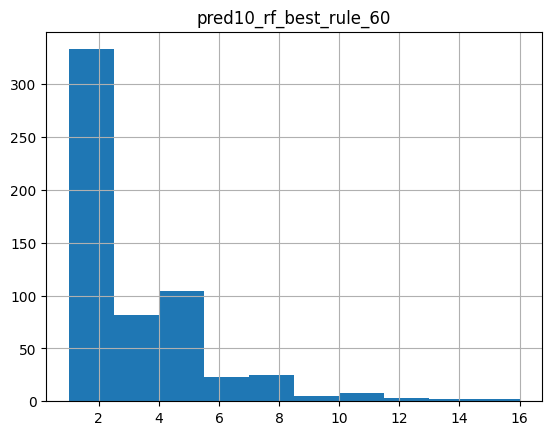

In [122]:
pred10_daily_positive_count.hist()


## Agg. stats on ALL predictions

In [124]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(model_df, to_predict='is_positive_growth_5d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    352
0    275
Name: count, dtype: int64
is_correct_pred0
1    0.561404
0    0.438596
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    7703
0    6310
Name: count, dtype: int64
is_correct_pred1
1    0.549704
0    0.450296
Na

In [125]:

# Easier solution not using regular expressions

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))

10
10


In [126]:

# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]


PREDICTIONS_ON_MODELS, IS_CORRECT_ON_MODELS

(['pred5_clf_10',
  'pred6_clf_best',
  'pred7_clf_best_rule_66',
  'pred8_clf_best_rule_78',
  'pred9_rf_best_rule_55',
  'pred10_rf_best_rule_60'],
 ['is_correct_pred5',
  'is_correct_pred6',
  'is_correct_pred7',
  'is_correct_pred8',
  'is_correct_pred9',
  'is_correct_pred10'])

In [127]:

# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
model_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                 test          train    validation
pred5_clf_10           count  27040.000000  118333.000000  27016.000000
                       sum    10761.000000   36951.000000  13080.000000
                       mean       0.397966       0.312263      0.484158
pred6_clf_best         count  27040.000000  118333.000000  27016.000000
                       sum     5245.000000   18440.000000   4579.000000
                       mean       0.193972       0.155831      0.169492
pred7_clf_best_rule_66 count  27040.000000  118333.000000  27016.000000
                       sum     1871.000000    4986.000000   1648.000000
                       mean       0.069194       0.042135      0.061001
pred8_clf_best_rule_78 count  27040.000000  118333.000000  27016.000000
                       sum      643.000000    2288.000000    769.000000
                       mean       0.023780       0.019335      0.028465
pred9_rf_best_rule_55  count  27040.000000  118333.000000  27016.000000
                       sum     6015.000000   41229.000000  10444.000000
                       mean       0.222448       0.348415      0.386586
pred10_rf_best_rule_60 count  27040.000000  118333.000000  27016.000000
                       sum     1703.000000   25509.000000   7266.000000
                       mean       0.062981       0.215570      0.268952

In [128]:

# 10 predictions stats (check TEST set)
model_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T


split                                       test          train    validation
pred0_manual_cci             count  27040.000000  118333.000000  27016.000000
                             sum      627.000000    2621.000000    616.000000
                             mean       0.023188       0.022149      0.022801
pred1_manual_prev_g1         count  27040.000000  118333.000000  27016.000000
                             sum    14013.000000   57470.000000  13351.000000
                             mean       0.518232       0.485663      0.494189
pred2_manual_prev_g1_and_snp count  27040.000000  118333.000000  27016.000000
                             sum     6997.000000   30025.000000   7267.000000
                             mean       0.258765       0.253733      0.268989
pred3_manual_gdp_and_fastd   count  27040.000000  118333.000000  27016.000000
                             sum    26978.000000  117159.000000  26960.000000
                             mean       0.997707       0.990079      0.997927
pred4_manual_gdp_and_wti30d  count  27040.000000  118333.000000  27016.000000
                             sum        0.000000       0.000000      0.000000
                             mean       0.000000       0.000000      0.000000
pred5_clf_10                 count  27040.000000  118333.000000  27016.000000
                             sum    10761.000000   36951.000000  13080.000000
                             mean       0.397966       0.312263      0.484158
pred6_clf_best               count  27040.000000  118333.000000  27016.000000
                             sum     5245.000000   18440.000000   4579.000000
                             mean       0.193972       0.155831      0.169492
pred7_clf_best_rule_66       count  27040.000000  118333.000000  27016.000000
                             sum     1871.000000    4986.000000   1648.000000
                             mean       0.069194       0.042135      0.061001
pred8_clf_best_rule_78       count  27040.000000  118333.000000  27016.000000
                             sum      643.000000    2288.000000    769.000000
                             mean       0.023780       0.019335      0.028465
pred9_rf_best_rule_55        count  27040.000000  118333.000000  27016.000000
                             sum     6015.000000   41229.000000  10444.000000
                             mean       0.222448       0.348415      0.386586
pred10_rf_best_rule_60       count  27040.000000  118333.000000  27016.000000
                             sum     1703.000000   25509.000000   7266.000000
                             mean       0.062981       0.215570      0.268952

# Trading Simulations

In [129]:

# current prediction
pred = 'pred6_clf_best'
model_df[['growth_future_5d','is_positive_growth_5d_future',pred]]


,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best
0,1.012456,1,0
1,1.015012,1,0
2,1.046056,1,0
3,1.002447,1,0
4,1.022283,1,0
...,...,...,...
179056,NaN,0,0
179057,NaN,0,1
179058,NaN,0,0
179059,NaN,0,0


In [130]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
model_df['sim1_gross_rev_pred6'] = model_df[pred] * 100 * (model_df['growth_future_5d']-1)


# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
model_df['sim1_fees_pred6'] = -model_df[pred] * 100 * 0.002


# NET REVENUE: GROSS_REVENUE + FEES
model_df['sim1_net_rev_pred6'] = model_df['sim1_gross_rev_pred6'] + model_df['sim1_fees_pred6']


COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
model_df[(model_df.split=='test')&(model_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
4555,2021-06-07,USDZAR=X,13.417940,1.021543,1,1,2.154277,-0.2,1.954277
4560,2021-06-14,USDZAR=X,13.707000,1.045845,1,1,4.584518,-0.2,4.384518
4566,2021-06-22,USDZAR=X,14.214500,1.002315,1,1,0.231453,-0.2,0.031453
4571,2021-06-29,USDZAR=X,14.247400,0.999530,0,1,-0.047030,-0.2,-0.247030
4573,2021-07-01,USDZAR=X,14.231500,1.003421,1,1,0.342060,-0.2,0.142060
...,...,...,...,...,...,...,...,...,...
179008,2024-05-29,USDTHB=X,36.573002,0.999480,0,1,-0.051954,-0.2,-0.251954
179032,2024-07-02,USDTHB=X,36.715000,0.991693,0,1,-0.830724,-0.2,-1.030724
179043,2024-07-18,USDTHB=X,35.867001,1.006440,1,1,0.644043,-0.2,0.444043
179044,2024-07-19,USDTHB=X,36.139999,1.001937,1,1,0.193690,-0.2,-0.006310


In [131]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (model_df.split=='test')&(model_df[pred]==1)
df_investments_count_daily = pd.DataFrame(model_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

8.0


In [132]:
# how many times do we
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,845.0,6.207101,2.939105,1.0,4.0,6.0,8.0,20.0


In [134]:
model_df[(model_df.split=='test')&(model_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()


,0
sim1_gross_rev_pred6,4826.80188
sim1_fees_pred6,-1049.00000
sim1_net_rev_pred6,3783.00188


In [136]:
%%time

# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(model_df[(model_df.split=='test')&(model_df[pred]==1)])} out of {len(model_df[(model_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  model_df['sim1_gross_rev_'+pred_prefix] = model_df[pred] * 100 * (model_df['growth_future_5d']-1)
  model_df['sim1_fees_'+pred_prefix] = -model_df[pred] * 100 * 0.002
  model_df['sim1_net_rev_'+pred_prefix] = model_df['sim1_gross_rev_'+pred_prefix] + model_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (model_df.split=='test')&(model_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(model_df[filter_test_and_positive_pred])
  sim1_gross_rev = model_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = model_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = model_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(model_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 5 * sim1_q75_investments_per_day # 5 days in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {model_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 627 out of 27040 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    527.405112
sim1_fees_pred0        -125.400000
sim1_net_rev_pred0      403.405112
dtype: float64
        Count Investments in 4 years (on TEST): 627
        Gross Revenue: $527
        Fees (0.2% for buy+sell): $125
        Net Revenue: $403
        Fees are 23 % from Gross Revenue
        Capital Required : $1000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $1403 (Vfinal)
        Average CAGR on TEST (4 years) : 1.088, or 8.8% 
        Average daily stats: 
            Average net revenue per investment: $0.64 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 14013 out of 27040 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    2746.1068

In [137]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

# final comparison
df_sim1_results


,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,627,527.405112,-125.4,403.405112,0.237768,0.643389,1.690027,1000.0,1.088418,1.403405
1,pred1_manual_prev_g1,14013,2746.106897,-2802.6,-40.293103,1.020572,-0.002875,16.583432,9500.0,0.998938,0.995759
2,pred2_manual_prev_g1_and_snp,6997,1542.088666,-1399.4,154.088666,0.907471,0.022022,16.310023,9500.0,1.004031,1.016220
3,pred3_manual_gdp_and_fastd,26978,4514.669922,-5395.6,-848.930078,1.195126,-0.031467,31.926627,16000.0,0.986463,0.946942
4,pred4_manual_gdp_and_wti30d,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,pred5_clf_10,10761,4547.986832,-2152.2,2403.186832,0.473220,0.223324,12.734911,10500.0,1.052875,1.228875
6,pred6_clf_best,5245,4826.801880,-1049.0,3783.001880,0.217328,0.721259,6.207101,4000.0,1.181060,1.945750
7,pred7_clf_best_rule_66,1871,2413.551821,-374.2,2041.551821,0.155041,1.091155,2.723435,2000.0,1.192284,2.020776
8,pred8_clf_best_rule_78,643,819.266034,-128.6,691.266034,0.156970,1.075064,1.919403,1000.0,1.140389,1.691266
9,pred9_rf_best_rule_55,6015,4668.702088,-1203.0,3471.502088,0.257673,0.577141,7.212230,5000.0,1.140900,1.694300


In [138]:


# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()
